<a href="https://colab.research.google.com/github/petrucior/verilog/blob/main/processador_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Projeto de processador (versão final)

Author: Petrúcio Medeiros

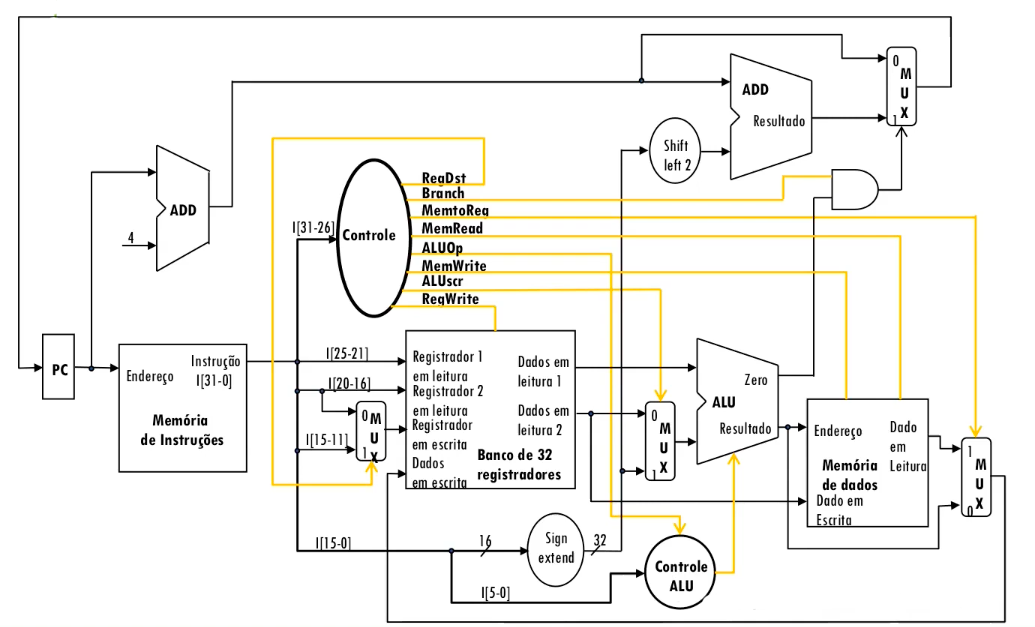


In [ ]:
# biblioteca do verilog
%%bash
sudo apt-get update
sudo apt-get install verilog iverilog gtkwave

In [2]:
!pip install git+https://github.com/lesc-ufv/cad4u >& /dev/null
!git clone https://github.com/lesc-ufv/cad4u >& /dev/null
%load_ext plugin

In [3]:
%%file pc.sv
// Contador de programa (PC)
module pc (clk, comandos, instruction, zero, address);
  // Declaracao de portas
  input clk, zero;
  input [9:0] comandos;
  input [31:0] instruction;
  output reg [31:0] address;

  // Variaveis intermediarias
  wire [31:0] extensao = { 16'd0, instruction[15:0] };
  wire [31:0] shift = extensao << 2;
  wire muxBranch = comandos[3]; // Branch
  wire muxJump = comandos[0]; // Jump

  // Iniciando endereco
  initial begin
    address = -32'd4;
  end

  // Funcionamento do contador
  always @( posedge clk ) begin
    address <= address + 32'd4;
    // Condicao do Jump
    if ( muxJump == 1'b1 ) begin  
      // Implementar ! ! !
    end
    // Condicao do Branch
    if (( muxBranch == 1'b1 ) & ( zero == 1'b1 ) & ( muxJump == 1'b0 )) begin
      address <= address + shift;
    end
  end
  
endmodule

Writing pc.sv


**Instruções:**

----

#![instrucoes](https://www.researchgate.net/profile/Shuichi-Ichikawa-2/publication/220239180/figure/fig1/AS:349293304139776@1460289421176/MIPS-instruction-format-18.png)

**lw rs, Offset(rt);**

* 6 bits ( opcode ) = **100011**
* 5 bits ( registrador fonte ) = **00000**
* 5 bits ( registrador destino ) = **00001**
* 16 bits ( imediato ) = **0000000000000011**


```

Ex.: lw $s1, 3($s0);
         $s1 = ($s0) + 32'd3;
         $s1 = 3;
```

**lw rs, Offset(rt);**

* 6 bits ( opcode ) = **100011**
* 5 bits ( registrador fonte ) = **00000**
* 5 bits ( registrador destino ) = **00010**
* 16 bits ( imediato ) = **0000000000000101**


```

Ex.: lw $s2, 5($s0);
         $s2 = ($s0) + 32'd5;
         $s2 = 5;
```

**add rs, rt, rd;**

* 6 bits ( opcode ) = **000000**
* 5 bits ( registrador origem 1 ) = **00001**
* 5 bits ( registrador origem 2 ) = **00010**
* 5 bits ( registrador destino ) = **00011**
* 5 bits ( shamt - operacoes de deslocamento ) = **00000**
* 6 bits ( funct - variacoes das operacoes especificadas do opcode ) = **100000**

```
Ex.: add $s3, $s1, $s2;
         $s3 = 3 + 5 = 8
```

---

**sub rs, rt, rd;**

* 6 bits ( opcode ) = **000000**
* 5 bits ( registrador origem 1 ) = **00010**
* 5 bits ( registrador origem 2 ) = **00001**
* 5 bits ( registrador destino ) = **00100**
* 5 bits ( shamt - operacoes de deslocamento ) = **00000**
* 6 bits ( funct - variacoes das operacoes especificadas do opcode ) = **100010**

```
Ex. sub $s4, $s2, $s1;
        $s4 = 5 - 3 = 2
```

---
**sw rs, Offset(rt);**

* 6 bits ( opcode ) = **101011**
* 5 bits ( registrador fonte ) = **00000**
* 5 bits ( registrador destino ) = **00011**
* 16 bits ( imediato ) = **0000000000000000**


```
Ex.: sw $s0, 3($s0);
         $s0 = ($s0) + 32'd3;
         $s0 = 8;
```

In [4]:
%%file instructions.txt
10001100
00000001
00000000
00000011
10001100
00000010
00000000
00000101
00000000
00100010
00011000
00100000
00000000
01000001
00100000
00100010
10101100
00000011
00000000
00000000

Writing instructions.txt


In [5]:
%%file instructions_memory.sv
`define NULL 0

// Memória de instrucoes
module instructions_memory ( clk, pc, instruction );
  // Declaracao de portas
  input clk;
  input [31:0] pc;
  output [31:0] instruction;

  integer f, r; // arquivo
  reg [7:0] data = 8'd0;
  integer counterMemory = 32'd0;

  // Criando uma memoria de instrucoes com 100 enderecos de 8 bits
  reg [7:0] memoriaInstrucoes [99:0];

  initial begin
    // Abrindo arquivo
    f = $fopen("/content/instructions.txt","r");
    // Se arquivo nao contem nenhuma informacao
    if ( f == `NULL ) begin
      $display("Arquivo sem instrucoes");
      $finish;
    end

    while (! $feof( f )) begin
      r = $fscanf( f,"%8b\n", data);
      memoriaInstrucoes[counterMemory] = data;
      counterMemory = counterMemory + 32'd1;
    end

    // Fechando arquivo
    $fclose( f );
  end

  // Atribuindo o valor da instrucao
  assign instruction = { memoriaInstrucoes[ pc + 32'd0 ],
                         memoriaInstrucoes[ pc + 32'd1 ],
                         memoriaInstrucoes[ pc + 32'd2 ],
                         memoriaInstrucoes[ pc + 32'd3 ] };
  
endmodule

Writing instructions_memory.sv


**Dados**: Cada linha do banco de registradores contém um dado.

```
  endereço do registrador
       | 5 bits  |
        --------------------------------------
dados  |    3    |    5    |  . . .  |        |  (32 bits)
        --------------------------------------
                     32 endereços
```

In [6]:
%%file register_bank.sv
// Banco de registradores
module register_bank ( clk, comandos, instruction, data_in, out1, out2, out3, memory );
  // Declaracao de portas
  input clk;
  input [9:0] comandos;
  input [31:0] instruction;
  input [31:0] data_in;
  output [31:0] out1, out2, out3;
  // 5 enderecos do banco de registradores
  output reg [127:0] memory;

  // Variaveis intermediarias
  wire RegDst = comandos[9];
  wire ALUscr = comandos[8];
  wire RegWrite = comandos[6];

  wire [4:0] addr_regd, addr_reg1, addr_reg2;
  assign addr_reg1 = instruction[25:21];
  assign addr_reg2 = instruction[20:16];
  assign addr_regd = ( RegDst == 1'b0 ) ? instruction[20:16] : instruction[15:11];
  
  wire [31:0] extensao = { 16'd0, instruction[15:0] };

  // Criando um banco de registradores com 32 enderecos de 32 bits
  reg [31:0] registerBank [31:0];

  // Inicializando o banco de registradores com valores iniciais
  integer i;
  initial begin
    for (i = 0; i < 32; i = i + 1) begin
      registerBank[i] <= 32'd0;
    end
  end
  
  // Descrevendo o comportamento de escrita no banco de registradores
  always @(posedge clk, data_in ) begin
    if ( RegWrite == 1'b1 ) begin
      registerBank[addr_regd] <= data_in;
    end
  end

  assign out1 = registerBank[addr_reg1];
  assign out2 = (ALUscr == 1'b1) ? extensao : registerBank[addr_reg2];
  assign out3 = registerBank[addr_reg2];

  always @( posedge clk, data_in ) begin
    memory <= {registerBank[0], registerBank[1], registerBank[2], registerBank[3]};
  end
  
endmodule

Writing register_bank.sv


In [7]:
%%file ula.sv
// Unidade logica aritmetica (ULA)
module ula ( control_ula, in1, in2, out, zero );
  // Declaracao de portas
  input [2:0] control_ula;
  input [31:0] in1, in2;
  output reg [31:0] out;
  output reg zero;

  // Descrevendo o comportamento da ULA
  always @( in1, in2, control_ula ) begin
    case ({control_ula})
      3'b010 : out = in1 + in2;
      3'b110 : out = in1 - in2;
      3'b000 : out = in1 & in2;
      3'b001 : out = in1 | in2;
      default : out = 32'd0;
    endcase
    if ( out == -32'd0 ) begin
      zero = 1'b1;
    end
    else begin
      zero = 1'b0;
    end
  end

endmodule

Writing ula.sv


In [8]:
%%file control.sv
// Controle
module control ( opcode, out );
  input [5:0] opcode;
  // RegDst, ALUscr, MemtoReg, RegWrite, MemRead, MemWrite, Branch, ALUOp, Jump
  output reg [9:0] out;

  always @( opcode ) begin
    casex ({opcode})
      6'b000000 : out = 10'b1001000100; // Tipo R
      6'b100011 : out = 10'b0111100000; // LW (Tipo I)
      6'b101011 : out = 10'bx1x0010000; // SW (Tipo I)
      6'b000100 : out = 10'bx0x0001010; // BEQ (Tipo I)
      6'b000010 : out = 10'bxxx0x0xxx1; // (Tipo J)
      default   : out = 10'bxxxxxxxxxx;
    endcase
  end

endmodule

Writing control.sv


In [9]:
%%file control_ULA.sv
// Controle
module control_ULA ( ULAOp, funct, out );
  input [1:0] ULAOp;
  input [5:0] funct;
  output reg [2:0] out;

  always @( ULAOp, funct ) begin
    casex ({ULAOp,funct})
      8'b00xxxxxx : out = 3'b010; // LW, SW (Tipo I)
      8'b01xxxxxx : out = 3'b110; // BEQ (Tipo I)
      8'b10100000 : out = 3'b010; // soma
      8'b10100010 : out = 3'b110; // subtracao
      8'b10100100 : out = 3'b000; // e
      8'b10100101 : out = 3'b001; // ou
      8'bxxxxxxxx : out = 3'bxxx; // Jump (Tipo J)
    endcase
  end
endmodule

Writing control_ULA.sv


In [10]:
%%file data_memory.sv
// Memoria de dados
module data_memory ( clk, addr, write_data, MemWrite, MemRead, MemtoReg, read_data, memory );
  input clk;
  input MemWrite, MemRead, MemtoReg;
  input [31:0] addr; // endereco memoria
  input [31:0] write_data; // dado escrito
  output reg [31:0] read_data; // dado lido
  output reg [127:0] memory;

  // Construindo memoria com 256 palavras de 32 bits
  reg [31:0] ram [0:255];

  // Inicializando a memoria com valores iniciais
  integer i;
  initial begin
    for (i = 0; i < 256; i = i + 1) begin
      ram[i] = i;
    end
  end

  always @( posedge clk, addr, MemWrite,MemRead,MemtoReg ) begin
    casex ({MemWrite,MemRead,MemtoReg})
      3'b000 : read_data <= addr;
      3'b011 : read_data <= ram[ addr ];
      3'b10x : ram[ addr ] <= write_data;
    endcase
  end

  always @( posedge clk, addr, MemWrite,MemRead,MemtoReg) begin
    memory <= {ram[0], ram[1], ram[2], ram[3]};
  end

endmodule

Writing data_memory.sv


In [11]:
%%file testbench.v

`include "pc.sv"
`include "instructions_memory.sv"
`include "control.sv"
`include "control_ULA.sv"
`include "register_bank.sv"
`include "ula.sv"
`include "data_memory.sv"

module testbench();
  // Test period
  parameter period = 2;

  reg clk;
  wire [9:0] commands;
  wire [31:0] instruction, address;
  wire zero;
  
  // Program counter
  pc pc(clk, commands, instruction, zero, address);

  // Instruction memory
  instructions_memory instruction_memory( clk, address, instruction );

  wire [5:0] opcode;
  assign opcode = instruction[31:26];
  
  // Control
  control c( opcode, commands);

  wire [31:0] data_ula, out1, out2, out3, r_data;
  wire [127:0] registradores; // 3 enderecos do banco de registradores

  // Register bank
  register_bank register_bank( clk, commands, instruction, data_ula, out1, out2, out3, registradores );

  wire [2:0] ula_control;

  wire [1:0] ULAOp;
  assign ULAOp = commands[2:1];
  
  wire [5:0] funct;
  assign funct = instruction[5:0];

  // ULA control
  control_ULA control_ULA( ULAOp, funct, ula_control );

  wire [31:0] result;
  
  // ULA
  ula ula( ula_control, out1, out2, result, zero );

  wire MemWrite, MemRead, MemtoReg;
  assign MemWrite = commands[4];
  assign MemRead = commands[5];
  assign MemtoReg = commands[7];

  wire [127:0] memoria;

  // Memory
  data_memory data_memory( clk, result, out3, MemWrite, MemRead, MemtoReg, data_ula, memoria );

  initial begin
    $dumpfile("cpu.vcd");
    $dumpvars;
    clk <= 0;
    $display("Registrador     |   Memoria");
    $display(" r0  r1  r2  r3 | m0 m1 m2 m3");
    $display("-------------------------");
    $monitor("  %1d   %1d   %1d   %1d | %1d  %1d  %1d  %1d", registradores[127:96], registradores[95:64], registradores[63:32], registradores[31:0], memoria[127:96], memoria[95:64], memoria[63:32], memoria[31:0]);
    #period;

    #period;

    #period;

    #period;

    #period;

    #period;

    #period;

    #period;
    
    #period;

    #period;

    #period;

    $finish;
  end

  always begin
    clk = ~clk;
    #period;
  end
endmodule

Writing testbench.v


In [12]:
%%bash
iverilog testbench.v -o cpu
vvp cpu

VCD info: dumpfile cpu.vcd opened for output.
Registrador     |   Memoria
 r0  r1  r2  r3 | m0 m1 m2 m3
-------------------------
  x   x   x   x | x  x  x  x
  0   0   0   0 | 0  1  2  3
  0   3   0   0 | 0  1  2  3
  0   3   5   0 | 0  1  2  3
  0   3   5   8 | 0  1  2  3
  0   3   5   8 | 8  1  2  3


Installing. Please wait... done!


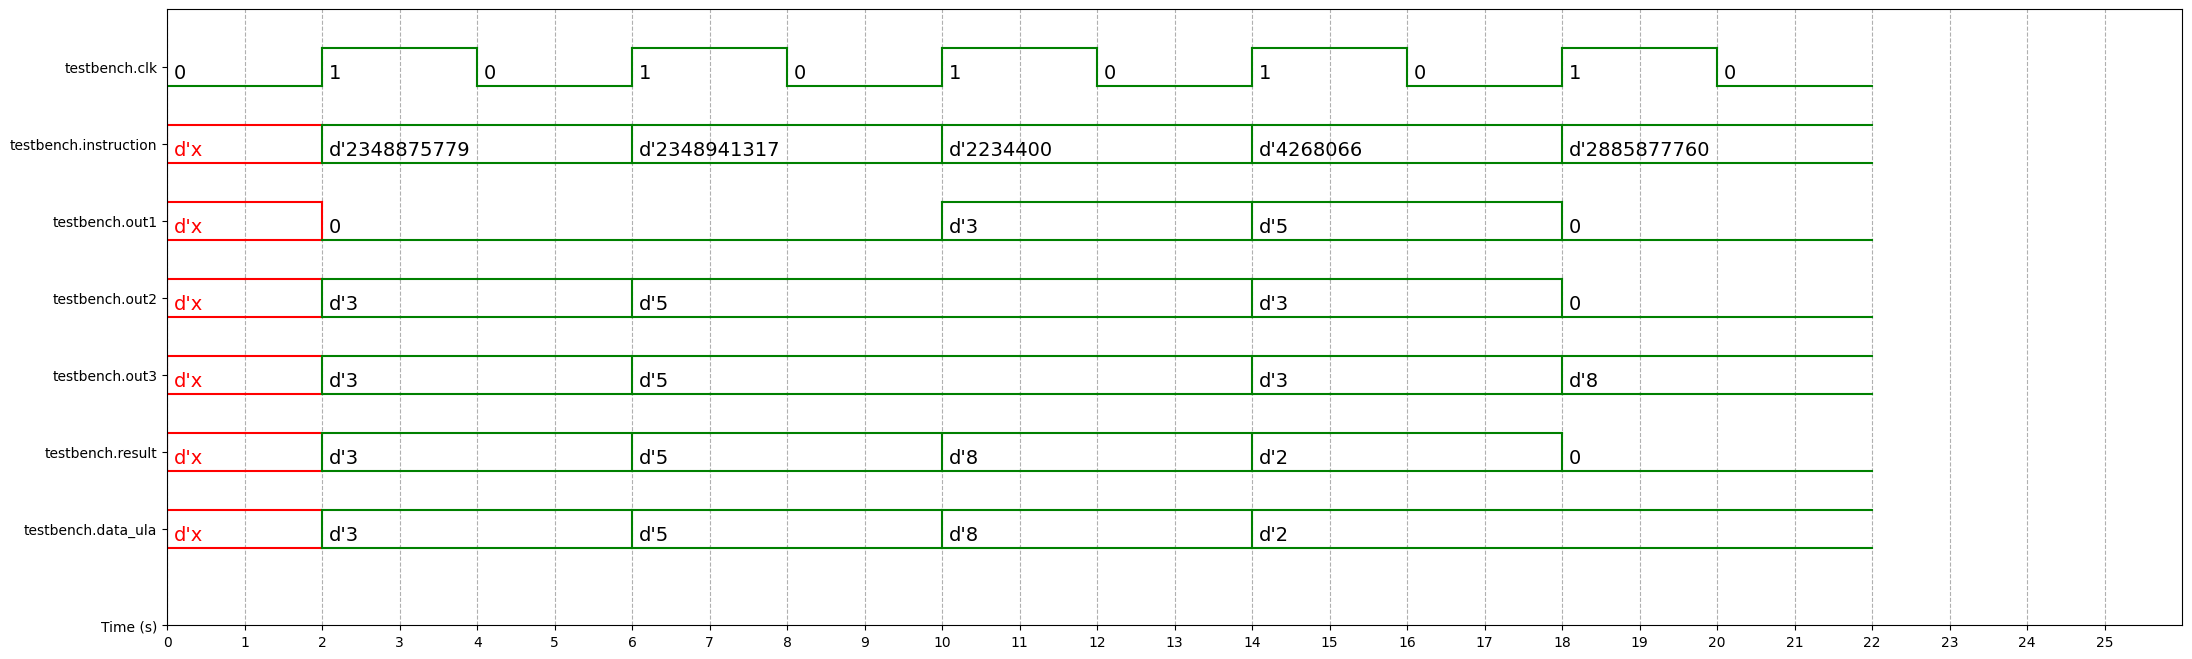

In [13]:
%%waveform cpu.vcd

sign_list = ['testbench.clk', 'testbench.instruction', 'testbench.out1', 'testbench.out2', 'testbench.out3', 'testbench.result', 'testbench.data_ula']
time_begin = 0
time_end = 25
base = 'dec' # bin, dec, dec2, hex, octal